# MNIST Multi-Modal Learning Practice Notebook

In this notebook, you will practice some of the core concepts we have presented. The overall pipeline is as follows:

---

## 1. Data Preparation

- Load the **MNIST** dataset.
- Split the dataset into **train**, **validation**, and **test** sets.
- Horizontally split each image into **upper** and **lower** halves.
- Pad the removed half with zeros to maintain consistent input shapes.

---

## 2. Model Definitions

Define three encoders:

1. **CNNEncoder**  
   - A simple CNN with two convolutional layers and pooling layers.

2. **MLPEncoder**  
   - A simple MLP with two fully connected layers.

3. **FusedModel**  
   - A combined model using:
     - `CNNEncoder` for the **upper half**.
     - `MLPEncoder` for the **lower half**.

---

## 3. Training and Evaluation

For each encoder:

### (i) CNNEncoder

- Use only the **upper half** of the input data.
- Train for **5 epochs**.
- Validate using the validation set.
- Evaluate performance on the test set.

### (ii) MLPEncoder

- Use only the **lower half** of the input data.
- Train for **5 epochs**.
- Validate using the validation set.
- Evaluate performance on the test set.

### (iii) FusedModel

- Use **both upper and lower halves** of the input data.
- Use the CNNEncoder (upper half) and the MLPEncoder (bottom half) and use concatenation to fuse the representations.
- Train for **5 epochs**.
- Validate using the validation set.
- Evaluate performance on the test set.

### (iv) Different Fusion Stategies
- Explore alternative fusion strategies such as for instance average fusion (Averaging representations).

### (v) Investigate how adding noise to the representations impacts performance
- Add increasing amounts of noise to one or both modalities and monitor performance.
- Visualize the fused representations using PCA or t-SNE.

---
Concepts introduced tomorrow:

### (vi) Self-supervised:
- Instead of directly fusing modalities, align the modalities using CLIP.
- Visualize the fused representations using PCA or t-SNE.
- Train a linear classifier on-top of the learned representations (keeping the encoders frozen).

### (vii) Alignment noise:
- Add increasing amounts of noise to one or both modalities and monitor performance.
- Visualize the fused representations using PCA or t-SNE.

# Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F


# Set hyperparams and load, split MNIST

In [3]:
# Hyperparameters
batch_size = 64
learning_rate = 0.01
num_epochs = 5

# Custom transform to add Gaussian noise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor: torch.Tensor) -> torch.Tensor:
        # torch should be imported from a previous cell (e.g., cell with id d13bd61f)
        return tensor + torch.randn_like(tensor) * self.std + self.mean
    
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

extra_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     AddGaussianNoise(std=0.1)] # Use the custom transform
)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

# Load MNIST dataset

extra_train_dataset = datasets.MNIST(root='./data', train=True, transform=extra_transform, download=True)
extra_train_loader = DataLoader(dataset=extra_train_dataset, batch_size=batch_size, shuffle=True)

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.7, 0.3])
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Visualize some images

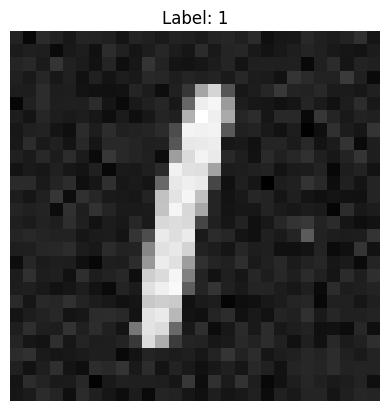

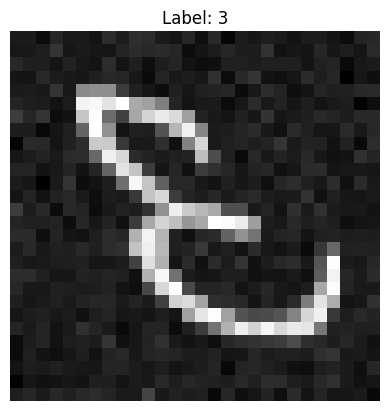

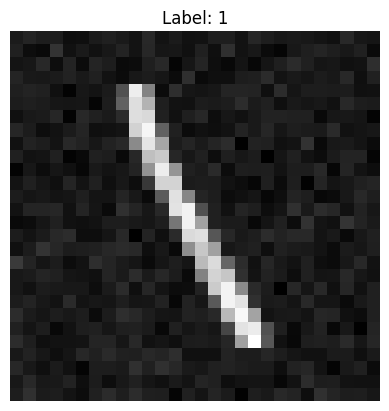

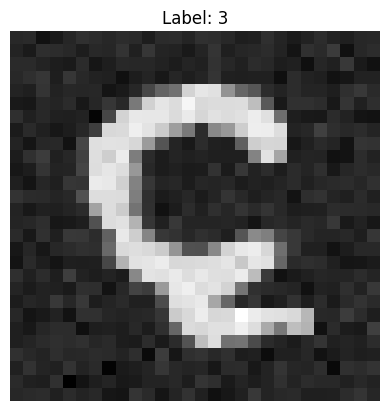

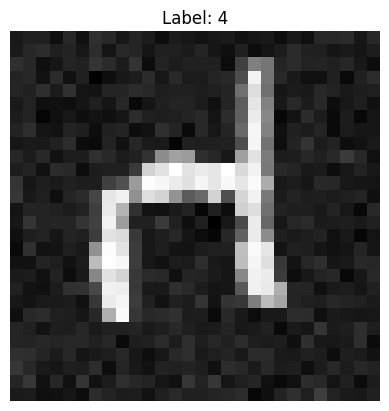

In [4]:
import matplotlib.pyplot as plt
import numpy as np

for images, labels in extra_train_loader:
    # Visualize the first few images in the batch
    num_images_to_show = 5
    for i in range(num_images_to_show):
        image = images[i]  # Get one image from the batch
        image = np.transpose(image, (1, 2, 0))  # Rearrange dimensions from CxHxW to HxWxC

        # Display the image
        plt.imshow(image, cmap='gray')
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')  # Turn off axis labels
        plt.show()

    break  # Exit the loop after visualizing the first batch

# Define our models - a CNN, an MLP, and a FusedModel

In [5]:
class CNNEncoder(nn.Module):
    """Simple CNN Encoder"""
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*7*7, 10) #This shape depends on the kernels and the input (split) shape

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x[0]))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        return x
    
    def inner_features(self, x: torch.Tensor) -> torch.Tensor:
        """Extract inner features from the input tensor."""
        x = F.relu(self.conv1(x[0]))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        return x

class MLP(nn.Module):
    """Simple 2-Layer MLP"""
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x[1].view(x[1].size(0), -1))) #Flatten all dimensions except batch_size
        x = self.fc2(x)
        return x
    
    def inner_features(self, x: torch.Tensor) -> torch.Tensor:
        """Extract inner features from the input tensor."""
        x = F.relu(self.fc1(x[1].view(x[1].size(0), -1))) #Flatten all dimensions except batch_size
        return x

# Fusing representations
class FusedModel(nn.Module):
    #Implement this in practical
    """Model that fuses CNN and MLP representations."""
    def __init__(self):
        super(FusedModel, self).__init__()
        self.cnn_encoder = CNNEncoder()
        self.mlp_encoder = MLP()
        self.fc = nn.Linear(20, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        cnn_out = self.cnn_encoder(x)
        mlp_out = self.mlp_encoder(x)
        fused = torch.cat((cnn_out, mlp_out), dim=1)
        return self.fc(fused)

# Utils

In [6]:
import torch.nn.functional as F

def prepare_data(data):
    """Splits MNIST images into two halves horizontally and pads to original shape."""
    upper_half = data[:, :, :14, :]  # Top half: [B, 1, 14, 28]
    lower_half = data[:, :, 14:, :]  # Bottom half: [B, 1, 14, 28]

    # Pad bottom 14 rows with zeros for upper_half
    upper_half_padded = F.pad(upper_half, pad=(0, 0, 0, 14))  # Pad rows: (left, right, top, bottom)

    # Pad top 14 rows with zeros for lower_half
    lower_half_padded = F.pad(lower_half, pad=(0, 0, 14, 0))  # Pad rows: (left, right, top, bottom)

    return upper_half_padded, lower_half_padded


def train_model(model: nn.Module, data_loader, optimizer: optim.Optimizer, criterion: nn.modules.loss._Loss, device: torch.device):
    """Train the model."""
    model.train()
    total_loss = 0.0
    
    for i, (images, labels) in enumerate(data_loader):
        optimizer.zero_grad()
        upper_half, lower_half = prepare_data(images)
        upper_half = upper_half.to(device)
        lower_half = lower_half.to(device)
        labels = labels.to(device)

        if isinstance(model, FusedModelCLIP):
            outputs = model.fine_tune_forward((upper_half, lower_half))
        else:
            outputs = model((upper_half, lower_half))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images[0].size(0)
        #print(f"Batch {i}: Loss = {loss.item()}")
    return total_loss / len(data_loader.dataset)


def evaluate_model(model: nn.Module, data_loader, criterion, device: torch.device):
    """Evaluate the model."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for (images, labels) in data_loader:
            upper_half, lower_half = prepare_data(images)
            upper_half = upper_half.to(device)
            lower_half = lower_half.to(device)
            labels = labels.to(device)  # Move labels to device
            if isinstance(model, FusedModelCLIP):
                outputs = model.fine_tune_forward((upper_half, lower_half))
            else:
                outputs = model((upper_half, lower_half))
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy

In [7]:
for images, _ in train_loader:
  upper_half, lower_half = prepare_data(images)
  print(upper_half.shape, lower_half.shape)
  print(images.shape)
  break

torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])


# Check that split works

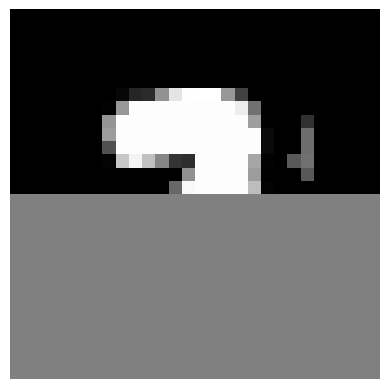

In [8]:
#Look at the first upper_half image
image = upper_half[0]  # Get one image from the batch
image = np.transpose(image, (1, 2, 0))  # Rearrange dimensions from CxHxW to HxWxC

# Display the image
plt.imshow(image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()



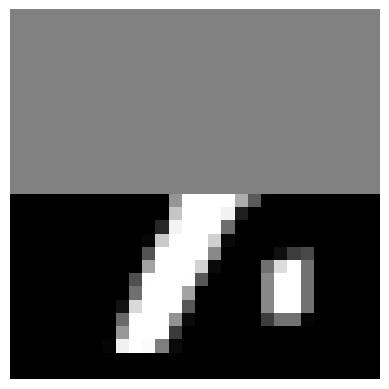

In [9]:
#Look at the first lower_half image
image = lower_half[0]  # Get one image from the batch
image = np.transpose(image, (1, 2, 0))  # Rearrange dimensions from CxHxW to HxWxC

# Display the image
plt.imshow(image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

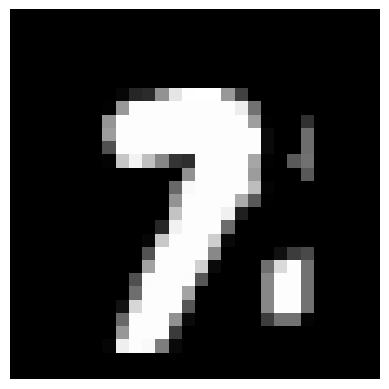

In [10]:
#look at first full image
image = images[0]
image = np.transpose(image, (1, 2, 0))  # Rearrange dimensions from CxHxW to HxWxC

# Display the image
plt.imshow(image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()



# Init and train CNN

In [11]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [12]:
#Initialize CNN
cnn_encoder = CNNEncoder()
criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_encoder.parameters(), lr=learning_rate)
cnn_encoder.to(device)

CNNEncoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=10, bias=True)
)

In [15]:
# Train and evaluate the CNN encoder
for epoch in range(num_epochs):
    avg_loss = train_model(cnn_encoder, train_loader, cnn_optimizer, criterion, device=device)
    print(f"Epoch {epoch+1}: CNN Encoder train loss {avg_loss}")
    avg_loss, accuracy = evaluate_model(cnn_encoder, val_loader, criterion, device=device)
    print(f"Epoch {epoch+1}: CNN Encoder val loss {avg_loss}, accuracy {accuracy:.4f}")

print("Done training! Evaluating on test set...")
#Test
avg_loss, accuracy = evaluate_model(cnn_encoder, test_loader, criterion, device=device)
print(f"CNN Encoder test loss {avg_loss}, accuracy {accuracy:.4f}")

Epoch 1: CNN Encoder train loss 0.0058038028506118625
Epoch 1: CNN Encoder val loss 0.2729466400278939, accuracy 0.9143
Epoch 1: CNN Encoder val loss 0.2729466400278939, accuracy 0.9143
Epoch 2: CNN Encoder train loss 0.0037103381932136557
Epoch 2: CNN Encoder train loss 0.0037103381932136557
Epoch 2: CNN Encoder val loss 0.23023758069674174, accuracy 0.9241
Epoch 2: CNN Encoder val loss 0.23023758069674174, accuracy 0.9241
Epoch 3: CNN Encoder train loss 0.0033742287099538817
Epoch 3: CNN Encoder train loss 0.0033742287099538817
Epoch 3: CNN Encoder val loss 0.21489575611220466, accuracy 0.9307
Epoch 3: CNN Encoder val loss 0.21489575611220466, accuracy 0.9307
Epoch 4: CNN Encoder train loss 0.0032024526126860154
Epoch 4: CNN Encoder train loss 0.0032024526126860154
Epoch 4: CNN Encoder val loss 0.20484759381082324, accuracy 0.9355
Epoch 4: CNN Encoder val loss 0.20484759381082324, accuracy 0.9355
Epoch 5: CNN Encoder train loss 0.00313474864171197
Epoch 5: CNN Encoder train loss 0.00

# Init and train MLP

In [16]:
#Initialize MLP
mlp = MLP()
criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)
mlp.to(device)

# Train and evaluate the MLP
for epoch in range(num_epochs):
    avg_loss = train_model(mlp, train_loader, mlp_optimizer, criterion, device=device)
    print(f"Epoch {epoch+1}: MLP train loss {avg_loss}")
    avg_loss, accuracy = evaluate_model(mlp, val_loader, criterion, device=device)
    print(f"Epoch {epoch+1}: MLP val loss {avg_loss}, accuracy {accuracy:.4f}")

print("Done training! Evaluating on test set...")
#Test
avg_loss, accuracy = evaluate_model(mlp, test_loader, criterion, device=device)
print(f"MLP test loss {avg_loss}, accuracy {accuracy:.4f}")

Epoch 1: MLP train loss 0.00991340921783731
Epoch 1: MLP val loss 0.5287083685133193, accuracy 0.8237
Epoch 1: MLP val loss 0.5287083685133193, accuracy 0.8237
Epoch 2: MLP train loss 0.00731618730617421
Epoch 2: MLP train loss 0.00731618730617421
Epoch 2: MLP val loss 0.4775525360637241, accuracy 0.8381
Epoch 2: MLP val loss 0.4775525360637241, accuracy 0.8381
Epoch 3: MLP train loss 0.006866506036548387
Epoch 3: MLP train loss 0.006866506036548387
Epoch 3: MLP val loss 0.4457718935012817, accuracy 0.8462
Epoch 3: MLP val loss 0.4457718935012817, accuracy 0.8462
Epoch 4: MLP train loss 0.006561918061758791
Epoch 4: MLP train loss 0.006561918061758791
Epoch 4: MLP val loss 0.45062526088290744, accuracy 0.8487
Epoch 4: MLP val loss 0.45062526088290744, accuracy 0.8487
Epoch 5: MLP train loss 0.006562941037828014
Epoch 5: MLP train loss 0.006562941037828014
Epoch 5: MLP val loss 0.5045190846390194, accuracy 0.8240
Done training! Evaluating on test set...
Epoch 5: MLP val loss 0.504519084

# Init and train FusedModel

In [17]:
#Initialize Fusion Encoder
fused_nn = FusedModel()
criterion = nn.CrossEntropyLoss()
fuse_optimizer =  optim.Adam(fused_nn.parameters(), lr=learning_rate)
fused_nn.to(device)


FusedModel(
  (cnn_encoder): CNNEncoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=3136, out_features=10, bias=True)
  )
  (mlp_encoder): MLP(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
  (fc): Linear(in_features=20, out_features=10, bias=True)
)

In [18]:
# Train and evaluate the Fused encoder
for epoch in range(num_epochs):
    avg_loss = train_model(fused_nn, train_loader, fuse_optimizer, criterion, device=device)
    print(f"Epoch {epoch+1}: Fusion Encoder train loss {avg_loss}")
    avg_loss, accuracy = evaluate_model(fused_nn, val_loader, criterion, device=device)
    print(f"Epoch {epoch+1}: Fusion Encoder val loss {avg_loss}, accuracy {accuracy:.4f}")

print("Done training! Evaluating on test set...")
#Test
avg_loss, accuracy = evaluate_model(fused_nn, test_loader, criterion, device=device)
print(f"Fusion Encoder test loss {avg_loss}, accuracy {accuracy:.4f}")

Epoch 1: Fusion Encoder train loss 0.005123117565133032
Epoch 1: Fusion Encoder val loss 0.15193250252803167, accuracy 0.9553
Epoch 1: Fusion Encoder val loss 0.15193250252803167, accuracy 0.9553
Epoch 2: Fusion Encoder train loss 0.0025945814618219933
Epoch 2: Fusion Encoder train loss 0.0025945814618219933
Epoch 2: Fusion Encoder val loss 0.1302639990746975, accuracy 0.9614
Epoch 2: Fusion Encoder val loss 0.1302639990746975, accuracy 0.9614
Epoch 3: Fusion Encoder train loss 0.002264532692619555
Epoch 3: Fusion Encoder train loss 0.002264532692619555
Epoch 3: Fusion Encoder val loss 0.23826409525341458, accuracy 0.9300
Epoch 3: Fusion Encoder val loss 0.23826409525341458, accuracy 0.9300
Epoch 4: Fusion Encoder train loss 0.0020957493463176348
Epoch 4: Fusion Encoder train loss 0.0020957493463176348
Epoch 4: Fusion Encoder val loss 0.12636359686321683, accuracy 0.9633
Epoch 4: Fusion Encoder val loss 0.12636359686321683, accuracy 0.9633
Epoch 5: Fusion Encoder train loss 0.001974873

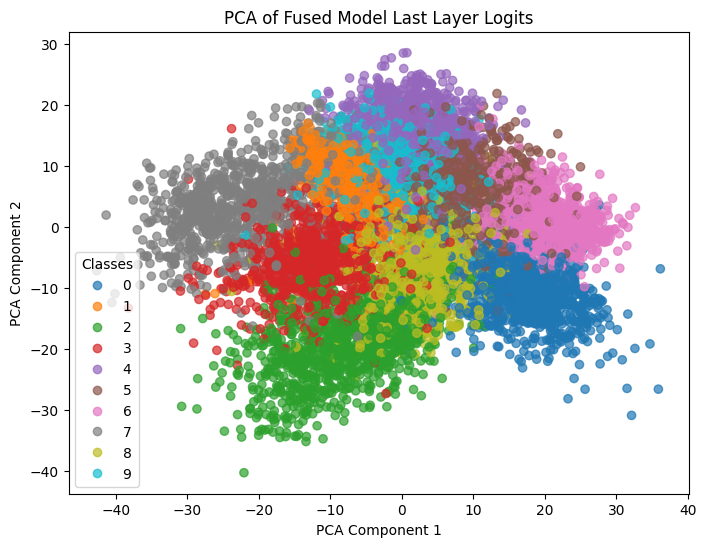

In [19]:
from sklearn.decomposition import PCA

# Get the last layer logits from the fused model and plot PCA colored by classes
import matplotlib.pyplot as plt

fused_nn.eval()
logits_list = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        upper_half, lower_half = prepare_data(images)
        upper_half = upper_half.to(device)
        lower_half = lower_half.to(device)
        logits = fused_nn((upper_half, lower_half))
        logits_list.append(logits.cpu())
        labels_list.append(labels.cpu())

logits_all = torch.cat(logits_list, dim=0).numpy()
labels_all = torch.cat(labels_list, dim=0).numpy()

# PCA
pca = PCA(n_components=2)
logits_pca = pca.fit_transform(logits_all)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(logits_pca[:, 0], logits_pca[:, 1], c=labels_all, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA of Fused Model Last Layer Logits")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

## (iv) Different Fusion Stategies


In [20]:
class FusedModel1(nn.Module):
    #Implement this in practical
    """Model that fuses CNN and MLP representations."""
    def __init__(self):
        super(FusedModel1, self).__init__()
        self.cnn_encoder = CNNEncoder()
        self.mlp_encoder = MLP()
        self.fc = nn.Linear(64*7*7 + 128, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        cnn_out = self.cnn_encoder.inner_features(x)
        mlp_out = self.mlp_encoder.inner_features(x)
        # average the two representations
        x = torch.cat((cnn_out, mlp_out), dim=1)
        fused = self.fc(x)
        return fused

In [21]:
class FusedModel2(nn.Module):
    #Implement this in practical
    """Model that fuses CNN and MLP representations."""
    def __init__(self):
        super(FusedModel2, self).__init__()
        self.cnn_encoder = CNNEncoder()
        self.mlp_encoder = MLP()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        cnn_out = self.cnn_encoder(x)
        mlp_out = self.mlp_encoder(x)
        # select the maximum of the two representations
        fused = torch.max(cnn_out, mlp_out)
        return fused

In [22]:
fused_nn = FusedModel1()
criterion = nn.CrossEntropyLoss()
fuse_optimizer =  optim.Adam(fused_nn.parameters(), lr=learning_rate)
fused_nn.to(device)


FusedModel1(
  (cnn_encoder): CNNEncoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=3136, out_features=10, bias=True)
  )
  (mlp_encoder): MLP(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
  (fc): Linear(in_features=3264, out_features=10, bias=True)
)

In [23]:
# Train and evaluate the Fused encoder
for epoch in range(num_epochs):
    avg_loss = train_model(fused_nn, train_loader, fuse_optimizer, criterion, device=device)
    print(f"Epoch {epoch+1}: Fusion Encoder train loss {avg_loss}")
    avg_loss, accuracy = evaluate_model(fused_nn, val_loader, criterion, device=device)
    print(f"Epoch {epoch+1}: Fusion Encoder val loss {avg_loss}, accuracy {accuracy:.4f}")

print("Done training! Evaluating on test set...")
#Test
avg_loss, accuracy = evaluate_model(fused_nn, test_loader, criterion, device=device)
print(f"Fusion Encoder test loss {avg_loss}, accuracy {accuracy:.4f}")

Epoch 1: Fusion Encoder train loss 0.0056973108852370865
Epoch 1: Fusion Encoder val loss 0.25393163565132354, accuracy 0.9208
Epoch 1: Fusion Encoder val loss 0.25393163565132354, accuracy 0.9208
Epoch 2: Fusion Encoder train loss 0.0033875252783209797
Epoch 2: Fusion Encoder train loss 0.0033875252783209797
Epoch 2: Fusion Encoder val loss 0.18392046723100874, accuracy 0.9458
Epoch 2: Fusion Encoder val loss 0.18392046723100874, accuracy 0.9458
Epoch 3: Fusion Encoder train loss 0.002950709104759707
Epoch 3: Fusion Encoder train loss 0.002950709104759707
Epoch 3: Fusion Encoder val loss 0.1742616847091251, accuracy 0.9482
Epoch 3: Fusion Encoder val loss 0.1742616847091251, accuracy 0.9482
Epoch 4: Fusion Encoder train loss 0.0026994905832578384
Epoch 4: Fusion Encoder train loss 0.0026994905832578384
Epoch 4: Fusion Encoder val loss 0.16668508747551175, accuracy 0.9536
Epoch 4: Fusion Encoder val loss 0.16668508747551175, accuracy 0.9536
Epoch 5: Fusion Encoder train loss 0.00258405

## (v) Investigate how adding noise to the representations impacts performance

## (vi) Self-supervised

In [24]:
class FusedModelCLIP(nn.Module):
    #Implement this in practical
    """Model that fuses CNN and MLP representations."""
    def __init__(self):
        super(FusedModelCLIP, self).__init__()
        self.cnn_encoder = CNNEncoder()
        self.mlp_encoder = MLP()
        self.cnn_downscale = nn.Linear(64*7*7, 128)  # Downscale CNN output to match MLP output
        self.classifier = nn.Linear(128*2, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        cnn_out = self.cnn_encoder.inner_features(x)
        mlp_out = self.mlp_encoder.inner_features(x)
        cnn_out = self.cnn_downscale(cnn_out)
        # average the two representations
        logits = torch.matmul(cnn_out, mlp_out.T)  # Compute logits as dot product
        return logits
    
    def fine_tune_forward(self, x: torch.Tensor) -> torch.Tensor:
        cnn_out = self.cnn_encoder.inner_features(x)
        mlp_out = self.mlp_encoder.inner_features(x)
        cnn_out = self.cnn_downscale(cnn_out)
        # average the two representations
        fused = torch.cat((cnn_out, mlp_out), dim=1)
        logits = self.classifier(fused)
        return logits
    
    def inner_features(self, x: torch.Tensor) -> torch.Tensor:
        """Extract inner features from the input tensor."""
        cnn_out = self.cnn_encoder.inner_features(x)
        mlp_out = self.mlp_encoder.inner_features(x)
        cnn_out = self.cnn_downscale(cnn_out)
        return torch.cat((cnn_out, mlp_out), dim=1)
    
    

In [25]:
def train_clip(model: nn.Module, data_loader, optimizer: optim.Optimizer, criterion: nn.modules.loss._Loss, device: torch.device):
    """Train the model."""
    model.train()
    total_loss = 0.0
    print("Training CLIP model...")
    for i, (images, labels) in enumerate(data_loader):
        #print(f"Processing batch {i+1}/{len(data_loader)}")
        if len(images) != batch_size:
            break
        optimizer.zero_grad()
        upper_half, lower_half = prepare_data(images)
        upper_half = upper_half.to(device)
        lower_half = lower_half.to(device)
        #labels = labels.to(device)

        outputs = model((upper_half, lower_half))
        labels = torch.arange(batch_size)
        labels = labels.to(device)  # Move labels to device
        loss_1 = criterion(outputs, labels)
        loss_2 = criterion(outputs.T, labels)  # Transpose for second loss
        loss = (loss_1 + loss_2) / 2  # Average the two losses
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images[0].size(0)
        #print(f"Batch {i}: Loss = {loss.item()}")
    return total_loss / len(data_loader.dataset)


def evaluate_clip(model: nn.Module, data_loader, criterion, device: torch.device):
    """Evaluate the model."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for (images, labels) in data_loader:
            upper_half, lower_half = prepare_data(images)
            upper_half = upper_half.to(device)
            lower_half = lower_half.to(device)
            labels = labels.to(device)  # Move labels to device

            outputs = model((upper_half, lower_half))
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy

In [30]:
clip_nn = FusedModelCLIP()
criterion = nn.CrossEntropyLoss()
fuse_optimizer =  optim.Adam(clip_nn.parameters(), lr=learning_rate)
clip_nn.to(device)

FusedModelCLIP(
  (cnn_encoder): CNNEncoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=3136, out_features=10, bias=True)
  )
  (mlp_encoder): MLP(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
  (cnn_downscale): Linear(in_features=3136, out_features=128, bias=True)
  (classifier): Linear(in_features=256, out_features=10, bias=True)
)

In [31]:
for epoch in range(25):
    avg_loss = train_clip(clip_nn, extra_train_loader, fuse_optimizer, criterion, device=device)
    print(f"Epoch {epoch+1}: Fusion Encoder train loss {avg_loss}")
    #avg_loss, accuracy = evaluate_clip(clip_nn, val_loader, criterion, device=device)
    #print(f"Epoch {epoch+1}: Fusion Encoder val loss {avg_loss}, accuracy {accuracy:.4f}")

print("Done training! Evaluating on test set...")
#Test
#avg_loss, accuracy = evaluate_clip(clip_nn, test_loader, criterion, device=device)
#print(f"Fusion Encoder test loss {avg_loss}, accuracy {accuracy:.4f}")

Training CLIP model...
Epoch 1: Fusion Encoder train loss 0.024343447756767275
Training CLIP model...
Epoch 1: Fusion Encoder train loss 0.024343447756767275
Training CLIP model...
Epoch 2: Fusion Encoder train loss 0.016518181649843852
Training CLIP model...
Epoch 2: Fusion Encoder train loss 0.016518181649843852
Training CLIP model...
Epoch 3: Fusion Encoder train loss 0.015439386261502902
Training CLIP model...
Epoch 3: Fusion Encoder train loss 0.015439386261502902
Training CLIP model...
Epoch 4: Fusion Encoder train loss 0.016995814657708008
Training CLIP model...
Epoch 4: Fusion Encoder train loss 0.016995814657708008
Training CLIP model...
Epoch 5: Fusion Encoder train loss 0.015136439263820647
Training CLIP model...
Epoch 5: Fusion Encoder train loss 0.015136439263820647
Training CLIP model...
Epoch 6: Fusion Encoder train loss 0.01673923739294211
Training CLIP model...
Epoch 6: Fusion Encoder train loss 0.01673923739294211
Training CLIP model...
Epoch 7: Fusion Encoder train l

In [32]:
# freeze the clip_nn network except the classifier layer
for param in clip_nn.parameters():
    param.requires_grad = False
for param in clip_nn.classifier.parameters():
    param.requires_grad = True
# Fine-tune the classifier layer
clip_optimizer = optim.Adam(clip_nn.classifier.parameters(), lr=learning_rate)
for epoch in range(5):
    avg_loss = train_model(clip_nn, train_loader, clip_optimizer, criterion, device=device)
    print(f"Epoch {epoch+1}: Fusion Encoder train loss {avg_loss}")
    avg_loss, accuracy = evaluate_model(clip_nn, val_loader, criterion, device=device)
    print(f"Epoch {epoch+1}: Fusion Encoder val loss {avg_loss}, accuracy {accuracy:.4f}")
print("Done fine-tuning! Evaluating on test set...")
#Test
avg_loss, accuracy = evaluate_model(clip_nn, test_loader, criterion, device=device)
print(f"Fusion Encoder test loss {avg_loss}, accuracy {accuracy:.4f}")


Epoch 1: Fusion Encoder train loss 0.012706697608743395
Epoch 1: Fusion Encoder val loss 0.750582388136122, accuracy 0.7599
Epoch 1: Fusion Encoder val loss 0.750582388136122, accuracy 0.7599
Epoch 2: Fusion Encoder train loss 0.010747334482414382
Epoch 2: Fusion Encoder train loss 0.010747334482414382
Epoch 2: Fusion Encoder val loss 0.6264466303189595, accuracy 0.7993
Epoch 2: Fusion Encoder val loss 0.6264466303189595, accuracy 0.7993
Epoch 3: Fusion Encoder train loss 0.010228758333694367
Epoch 3: Fusion Encoder train loss 0.010228758333694367
Epoch 3: Fusion Encoder val loss 0.6550546561347114, accuracy 0.7841
Epoch 3: Fusion Encoder val loss 0.6550546561347114, accuracy 0.7841
Epoch 4: Fusion Encoder train loss 0.010091649532318116
Epoch 4: Fusion Encoder train loss 0.010091649532318116
Epoch 4: Fusion Encoder val loss 0.6379822290738424, accuracy 0.7902
Epoch 4: Fusion Encoder val loss 0.6379822290738424, accuracy 0.7902
Epoch 5: Fusion Encoder train loss 0.009861559362638564
Ep

## (vii) Alignment noise

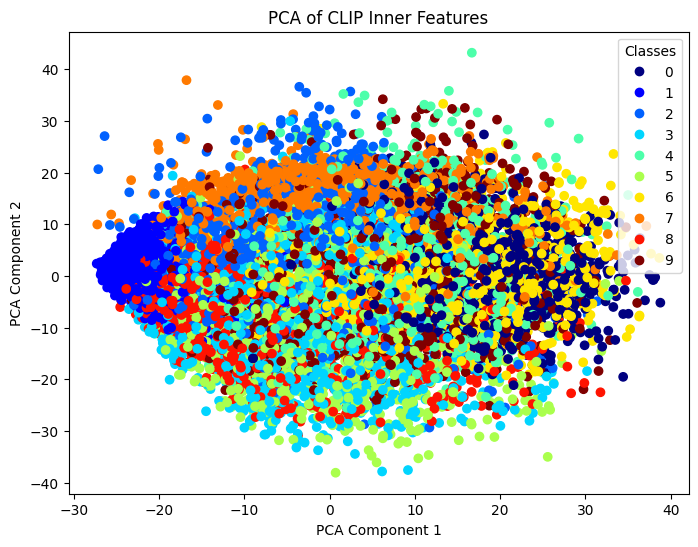

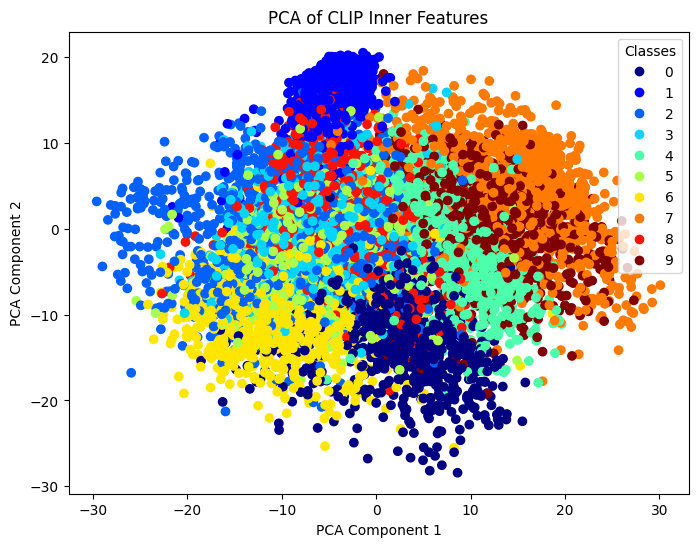

In [33]:
# take the inner features of the clip_nn and plot the first two pca dimensions an color by classes
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the inner features
clip_nn.eval()
with torch.no_grad():
# Get all inner features from the test set
    features = []
    labels_list = []
    final_features = []
    for images, labels in test_loader:
        upper_half, lower_half = prepare_data(images)
        upper_half = upper_half.to(device)
        lower_half = lower_half.to(device)
        inner_features = clip_nn.inner_features((upper_half, lower_half))
        final_layer = clip_nn.classifier(inner_features)
        features.append(inner_features.cpu())
        final_features.append(final_layer.cpu())
        labels_list.append(labels.cpu())
    features = torch.cat(features, dim=0)
    final_features = torch.cat(final_features, dim=0)
    labels = torch.cat(labels_list, dim=0)
# Convert features to numpy for PCA
features = features.numpy()
# Perform PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(features)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels.numpy(), cmap = 'jet')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA of CLIP Inner Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


final_features = final_features.numpy()
# Perform PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(final_features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels.numpy(), cmap = 'jet')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA of CLIP Inner Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()